In [209]:
import pandas as pd
import numpy as np
import osmnx as ox
ox.settings.use_cache = True
ox.settings.log_console = True
import pulp as plp
import matplotlib.pyplot as plt
import networkx as nx

# 1) Preprocess data

Load the data with areas, i.e. demand points and warehouses.

In [210]:
df_a = pd.read_csv("data/areas_latlong.csv")
df_a.head()

Area        lat       long
0  Helsingin keskusta  60.168741  24.940895
1           Punavuori  60.161237  24.936505
2     Kaartinkaupunki  60.165214  24.947222
3         Kaivopuisto  60.156843  24.956721
4                Eira  60.156191  24.938375

In [211]:
df_w = pd.read_csv("data/warehouses.csv")
df_w.head()

Warehouse        lat       long  mincap  maxcap
0       Kamppi  60.167458  24.931075     200     600
1  Munkkiniemi  60.198270  24.875989     200     600
2       Pasila  60.202785  24.925894     500    1500
3      Maunula  60.229804  24.930579     300     900
4        Malmi  60.251022  25.010563     500    1500

Extract the data.

In [212]:
Nd = len(df_a)
Nw = len(df_w)

demand_lat = df_a["lat"].tolist()
demand_long = df_a["long"].tolist()
warehouse_lat = df_w["lat"].tolist()
warehouse_long = df_w["long"].tolist()

warehouse_min = df_w["mincap"]
warehouse_max = df_w["maxcap"]

# Set total demand
D = 5000

Print out data.

In [213]:
print(f"Number of demand points: {Nd}")
print(f"Number of warehouses: {Nw}")
print(f"Total demand: {D}")
print(f"Sum of minimum capacities of warehouses: {sum(warehouse_min)}")
print(f"Sum of maximum capacities of warehouses: {sum(warehouse_max)}")
print(f"Average demand per demand point: {round(D/Nd,1)}")
print(f"Average demand per warehouse: {round(D/Nw,1)}")

Number of demand points: 74
Number of warehouses: 8
Total demand: 5000
Sum of minimum capacities of warehouses: 2400
Sum of maximum capacities of warehouses: 7200
Average demand per demand point: 67.6
Average demand per warehouse: 625.0


# 2) Initialize a road network

Initialize the road network.

In [214]:
#G = ox.graph_from_point(center_point=(60.15, 25.01), dist=15000,network_type="drive",dist_type="bbox")

Save to file.

In [215]:
#ox.save_graphml(G, 'data/graph.graphml')

Load from file.

In [216]:
G = ox.load_graphml('data/graph.graphml')

Plot the network.

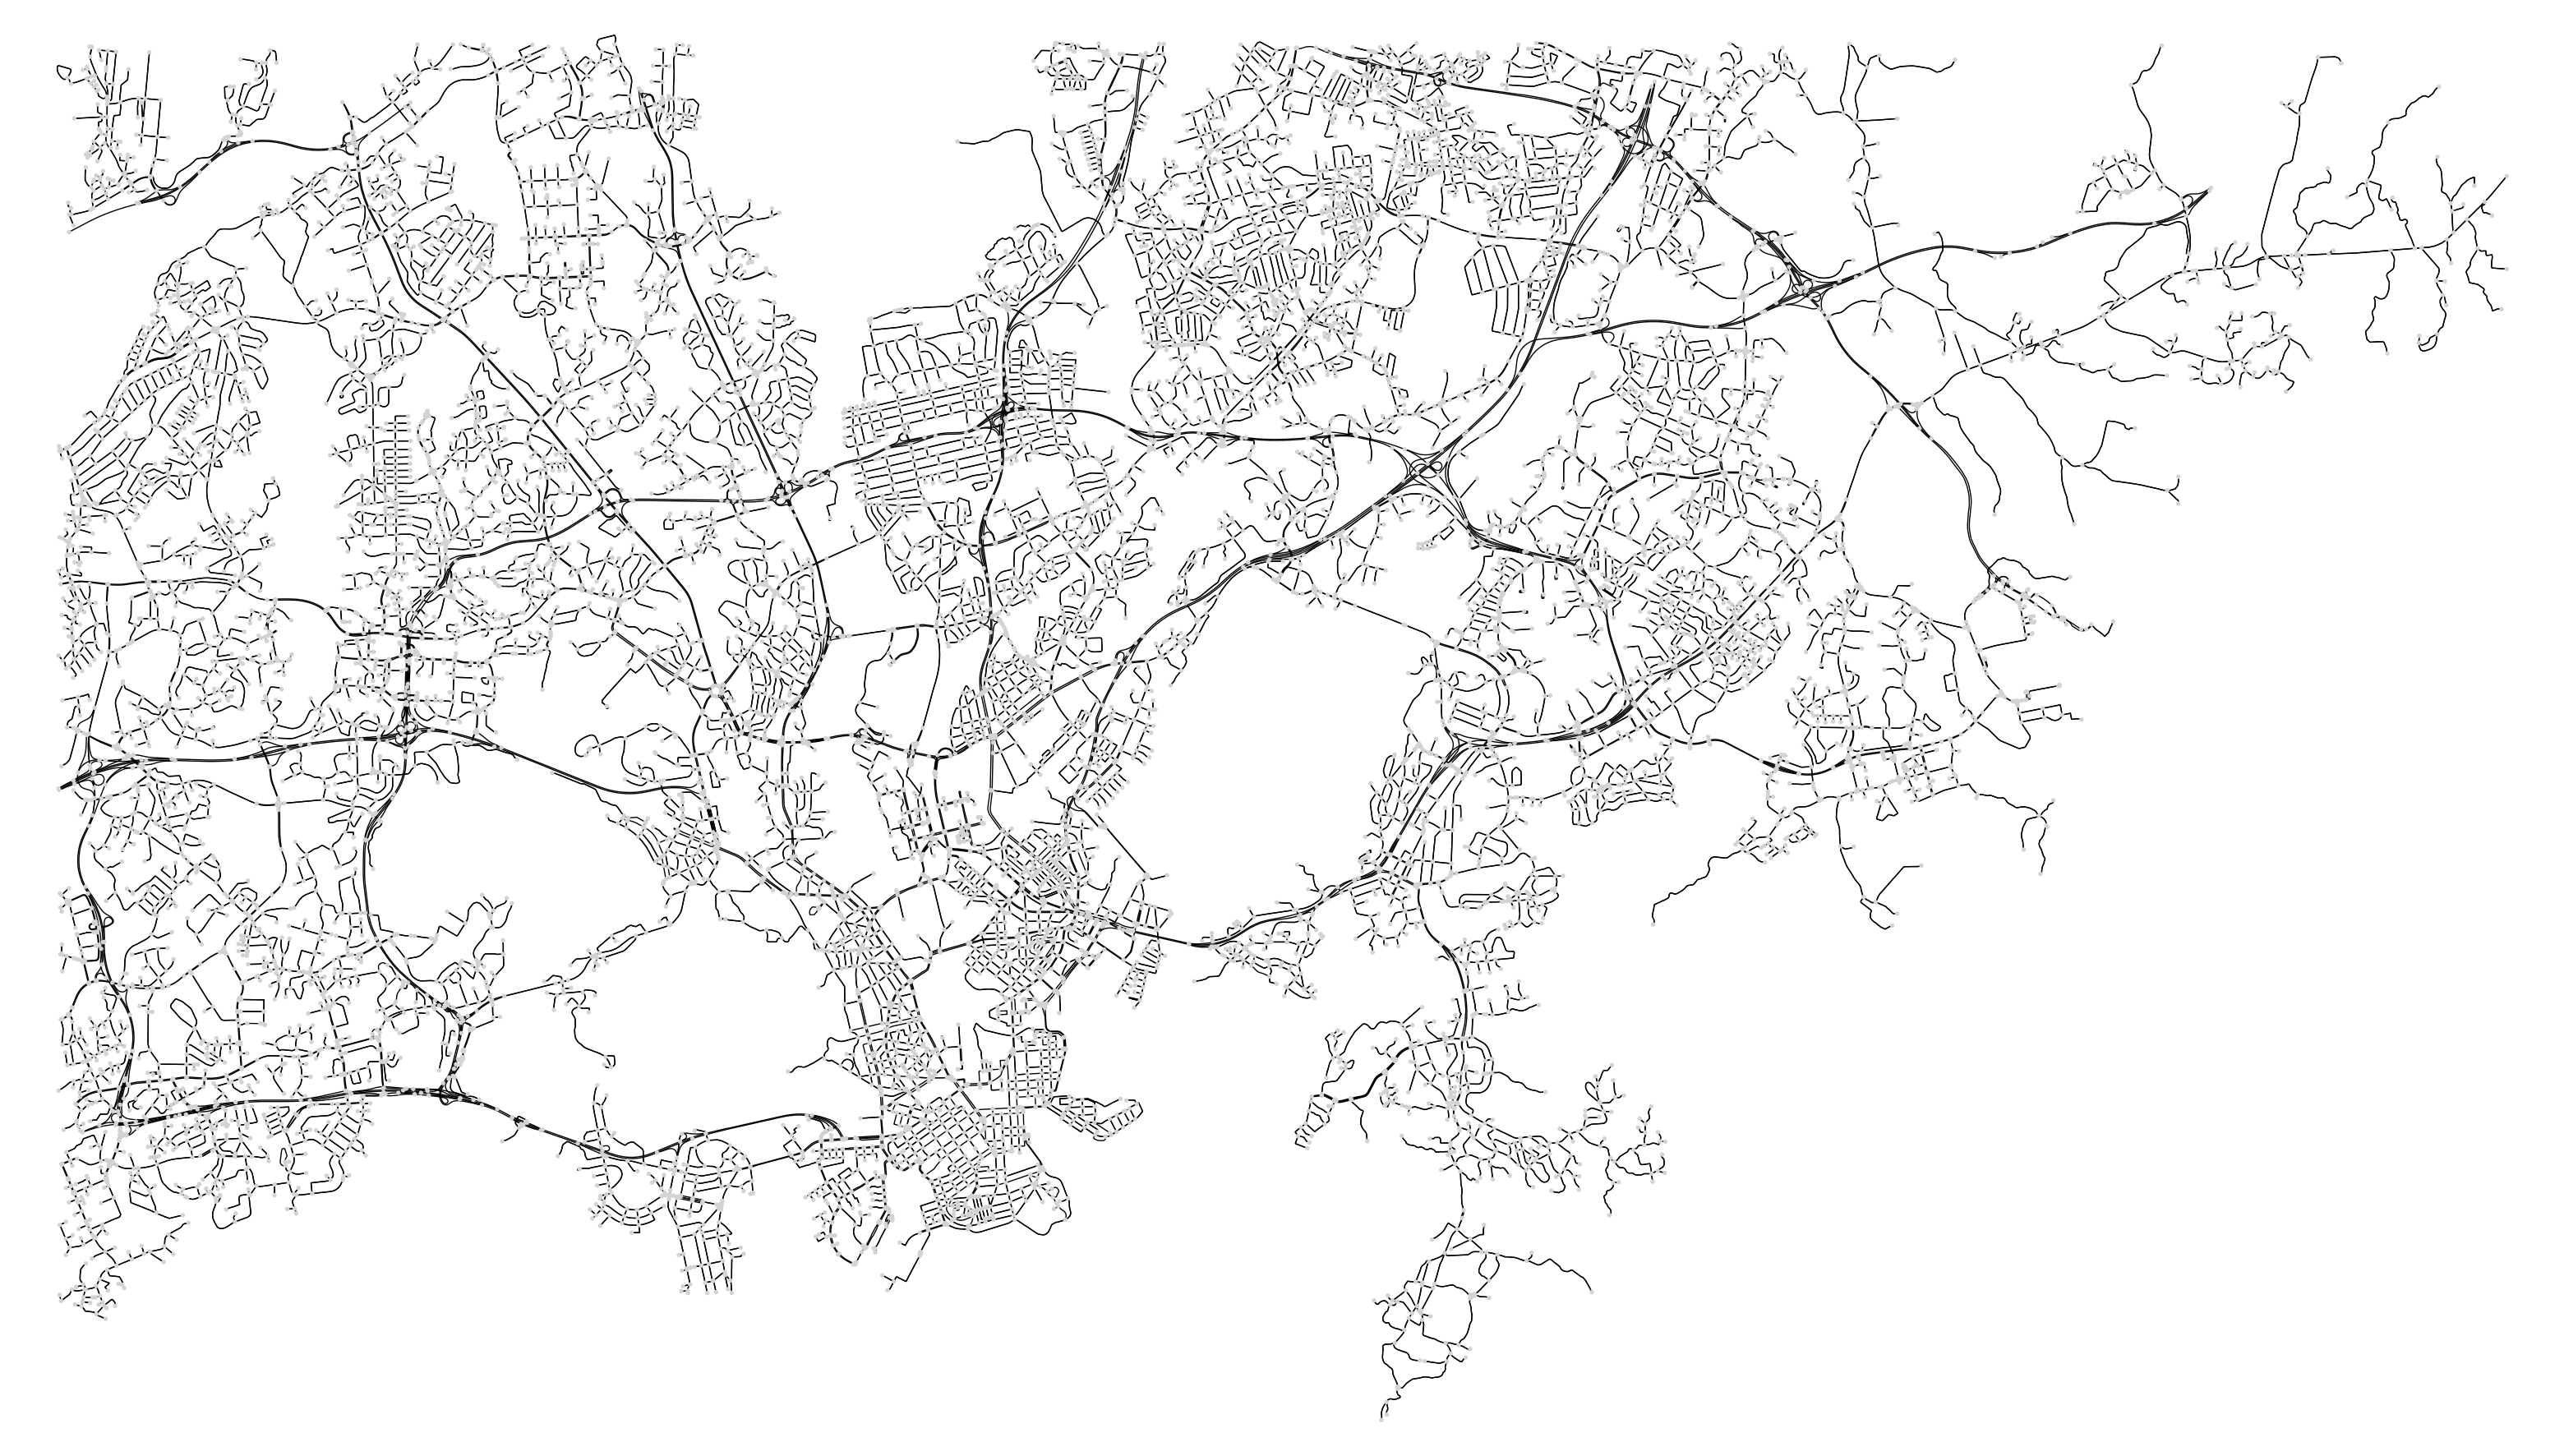

(<Figure size 4000x4000 with 1 Axes>, <AxesSubplot: >)

In [217]:
ox.plot_graph(G, figsize=(40,40),bgcolor="white",node_color="lightgrey",edge_color = "black")

# 3) Implement optimization model

In [218]:
def build_model(cost,avgdemand):
    opt_model = plp.LpProblem(name="MIP_Model")

    # Sets
    set_I = range(0, Nw)
    set_J = range(0, Nd)

    # Variables
    x  = {(i,j):
            plp.LpVariable(cat=plp.LpBinary, name="x_{0}_{1}".format(i,j)) 
        for i in set_I for j in set_J}

    o  = {(i):
            plp.LpVariable(cat=plp.LpBinary, name="o_{0}".format(i)) 
        for i in set_I}

    # Constraints
    for i in set_I:
        opt_model += (plp.lpSum([x[i,j]*avgdemand for j in set_J]) <= warehouse_max[i]* o[i])
        
    for i in set_I:
        opt_model += (plp.lpSum([x[i,j]*avgdemand for j in set_J]) >= warehouse_min[i] * o[i])

    constraints_eq = {j : opt_model.addConstraint(
            plp.LpConstraint(
                e=plp.lpSum(x[i,j] for i in set_I),
                sense=plp.LpConstraintEQ,
                rhs=1,
                name="constraint_eq_{0}".format(j)
            )
        ) for j in set_J}

    # Objective
    objective = plp.lpSum(x[i,j] * cost[i,j] for i in set_I for j in set_J)

    # for minimization
    opt_model.sense = plp.LpMinimize
    opt_model.setObjective(objective)
    return opt_model

# 4) Solution for Euclidean distances

Euclidean distance function

In [219]:
import math
from math import radians, cos, sin, asin, sqrt

def euc(w, l):
    R = 6370
    lat1 = radians(w[0])
    lon1 = radians(w[1])
    lat2 = radians(l[0])
    lon2 = radians(l[1])

    dlon = lon2 - lon1
    dlat = lat2- lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    distance = R * c * 1000
    return distance

Compute euclidean distances between each warehouse and demand point.

In [220]:
c = np.zeros((Nw,Nd))
for i in range(Nw):
    w = (warehouse_lat[i], warehouse_long[i])
    for j in range(Nd):
        l = (demand_lat[j], demand_long[j])
        c[i][j] = euc(w,l)

Solve the problem with euclidean distances.

In [221]:
avgdemand = int(D/Nd)
model = build_model(c,avgdemand)

model.solve(plp.PULP_CBC_CMD(msg=0))
print("Status:", plp.LpStatus[model.status])

Status: Optimal


Retrieve results.

In [222]:
def get_res_dict(model):
    # Construct dictionary with warehouse -> [demand points] it delivers to
    wh_to_demand = {}
    for v in model.variables():

        if v.varValue:
            if v.varValue > 0:
                if (v.name[0] != "o"):
                    string_sol = v.name.split("_")

                    wh = int(string_sol[1]) # index of warehouse
                    loc = int(string_sol[2]) # index of demand point

                    if wh in wh_to_demand:
                        wh_to_demand[wh].append(loc)
                    else:
                        wh_to_demand[wh] = [loc]
    return wh_to_demand

In [223]:
wh_to_demand = get_res_dict(model)

Plot solution.

/var/folders/8v/k4xkmlyj2332pfk5hbncd76h0000gn/T/ipykernel_88267/2341832273.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot([wy,ly],[wx,lx], 'bo', linestyle="--", linewidth=4, c=colors_palette[w])


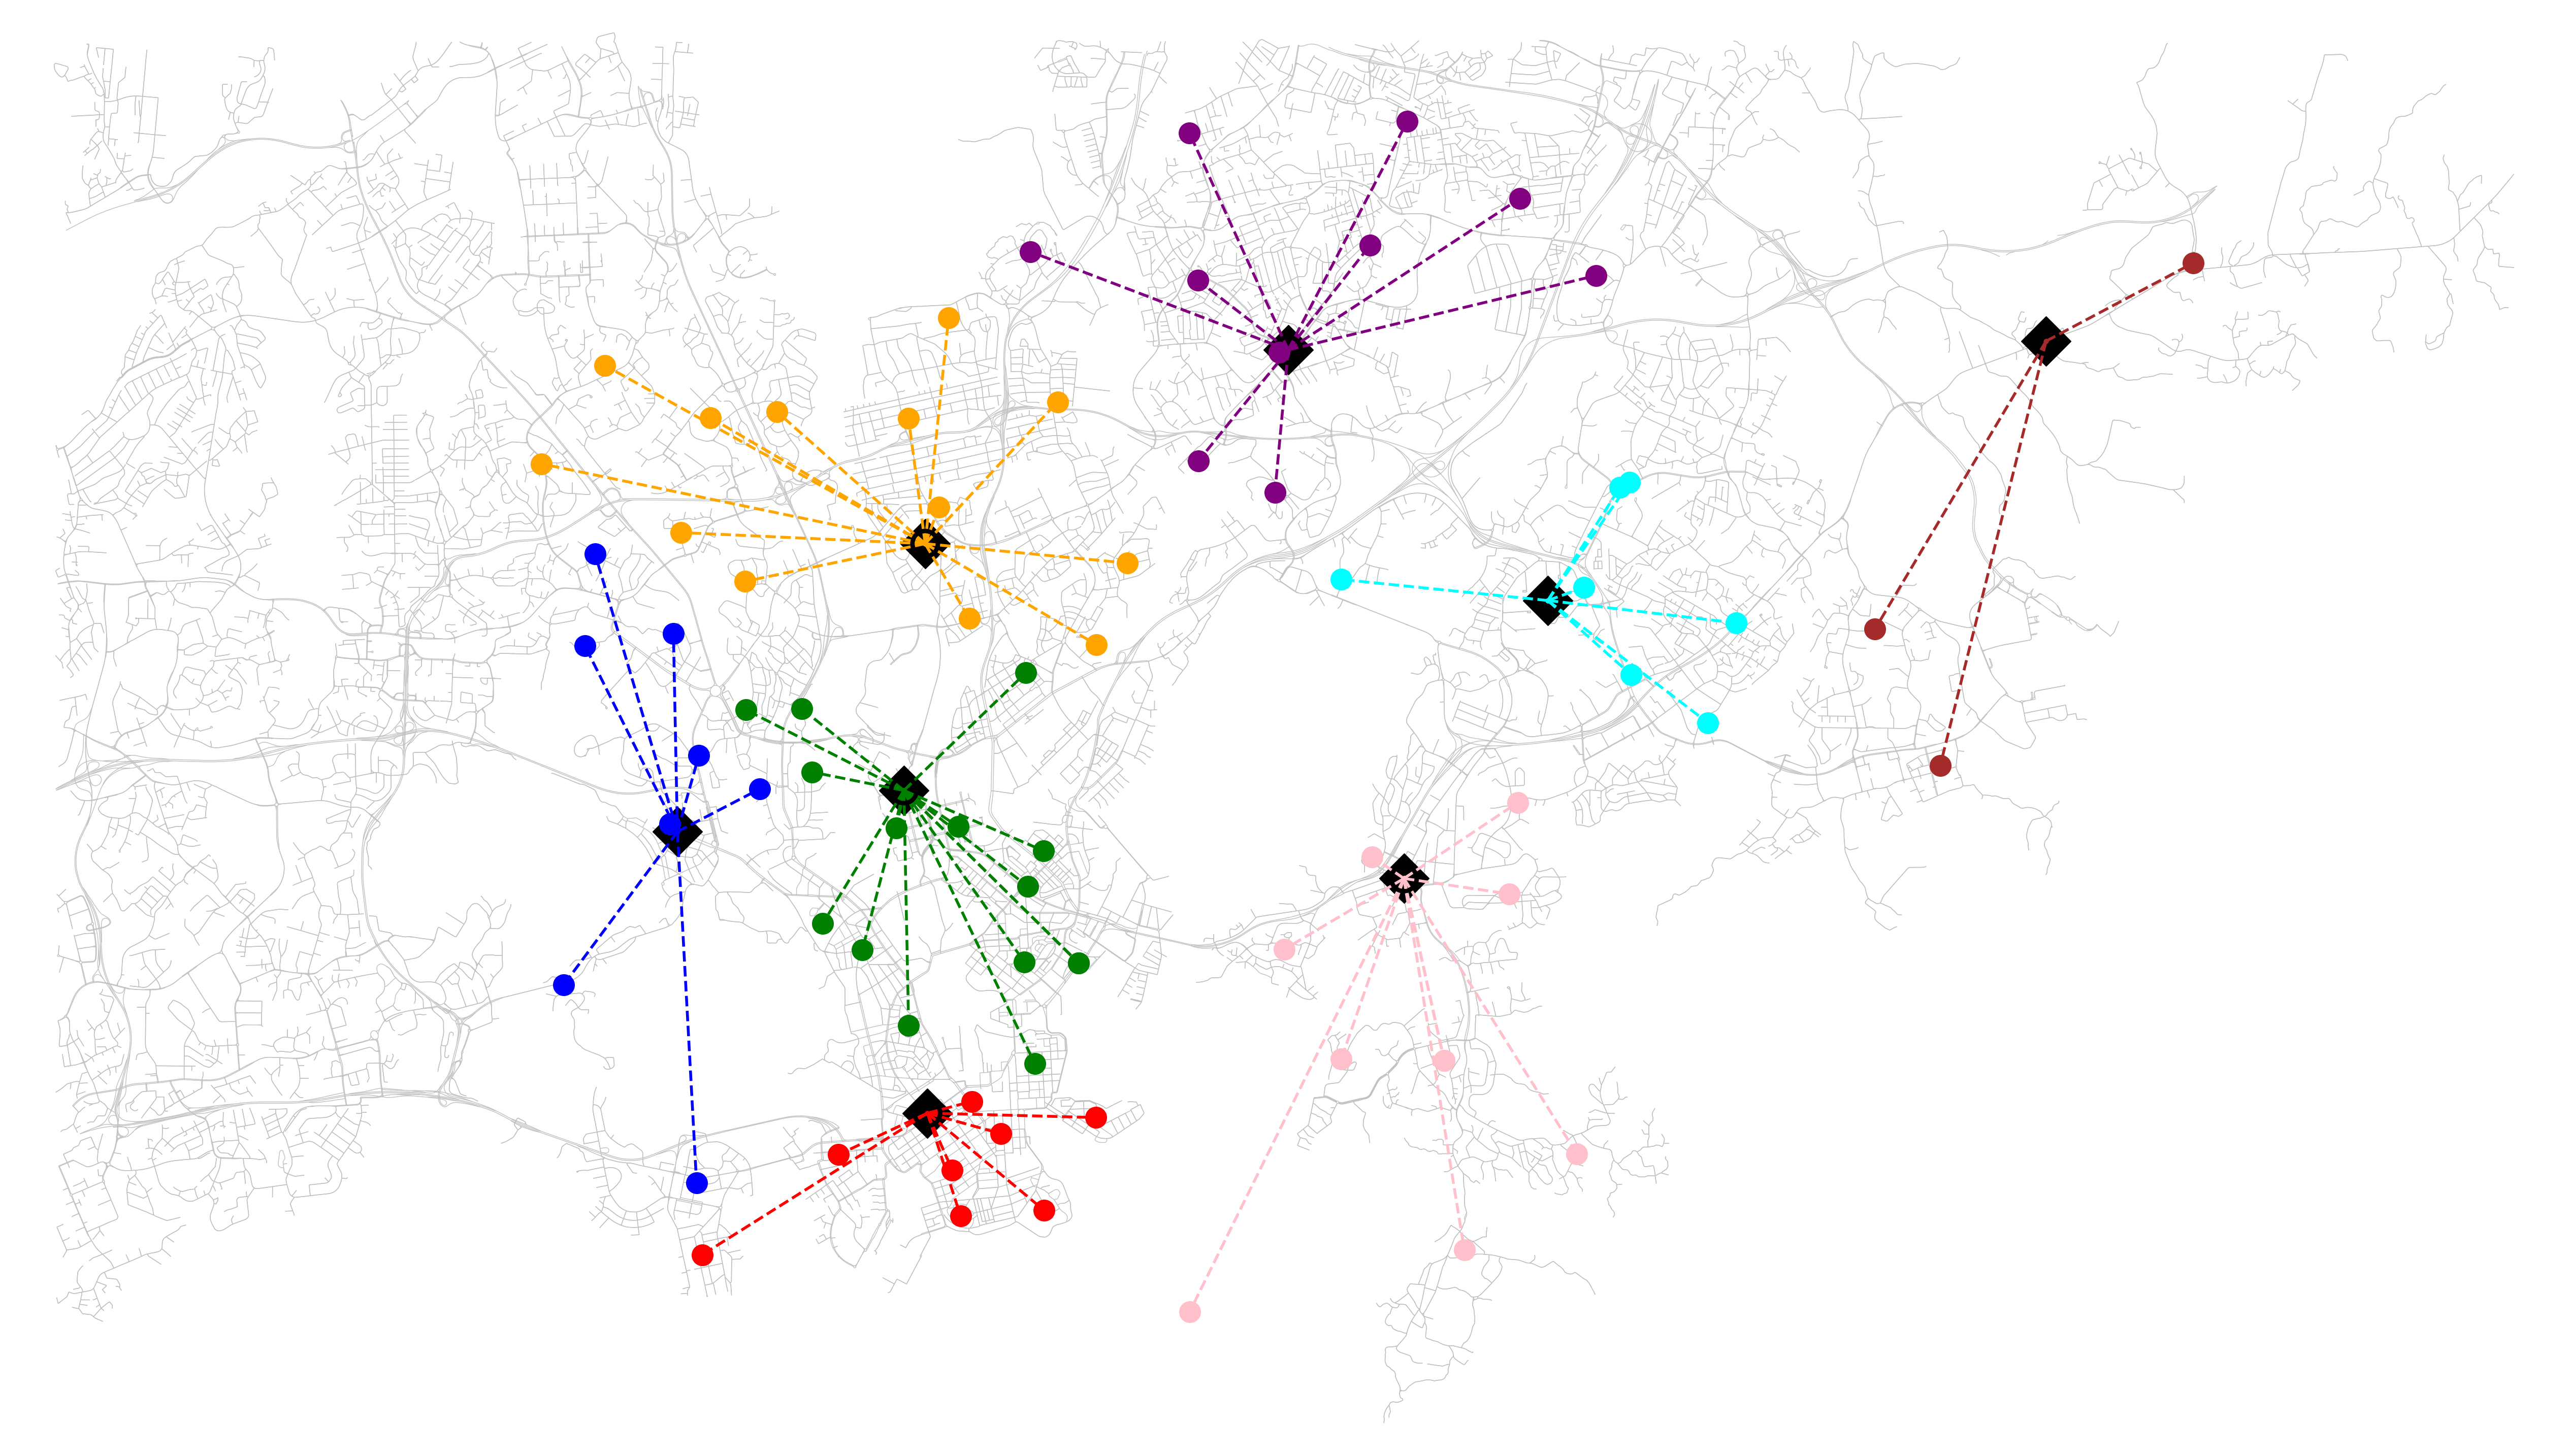

In [224]:
fig, axis = ox.plot_graph(G, figsize=(65,65),bgcolor="white",node_size=0,edge_color = "silver", show=False, close=False)

colors_palette = ["red","blue","green","orange","purple","pink","cyan","brown","lime","gold"]
for w in wh_to_demand:
    wx = warehouse_lat[w]
    wy = warehouse_long[w]

    plt.plot(wy,wx,c='black',marker='D',markersize=50)
    for l in wh_to_demand[w]:
        lx = demand_lat[l]
        ly = demand_long[l]
        plt.plot(ly,lx,c=colors_palette[w],marker='o',markersize=30)
        plt.plot([wy,ly],[wx,lx], 'bo', linestyle="--", linewidth=4, c=colors_palette[w])

# 5) Solution for road network distances

Compute road distances using shortest path in our network.

In [225]:
## Edges have speeds and times (equaling distance)
#G = ox.distance.add_edge_lengths(G) 
#
## Below for travel time instead of distance
##G = ox.add_edge_speeds(G) 
##G = ox.add_edge_travel_times(G) 
#
#c_road = np.zeros((Nw,Nd))
#for i in range(Nw):
#    start_node = ox.distance.nearest_nodes(G, warehouse_lat[i],warehouse_long[i], return_dist=False)
#    for j in range(Nd):
#        end_node = ox.distance.nearest_nodes(G, demand_lat[i],demand_long[i], return_dist=False)
#        c_road[i][j] = nx.shortest_path_length(G, start_node, end_node, weight='travel_time')

Save to csv-file.

In [226]:
#c_df = pd.DataFrame(c_road)
#c_df.to_csv("data/costs.csv", sep=";",index=False)
##c_df.to_csv("data/costs_time.csv", sep=";",index=False)

Load from csv-file.

In [227]:
c_road = pd.read_csv("data/costs.csv", sep=";").to_numpy()
# Load also travel distance network for results

Run model with road distances as cost function.

In [228]:
avgdemand = int(D/Nd)
model_road = build_model(c_road,avgdemand)

model_road.solve(plp.PULP_CBC_CMD(msg=0))
print("Status:", plp.LpStatus[model_road.status])

Status: Optimal


In [229]:
wh_to_demand_road = get_res_dict(model_road)

Build graphical solution.

In [230]:
colors_palette = ["red","blue","green","orange","purple","pink","cyan","brown"]
color_set = []
routes = [] # Solution routes

for i in wh_to_demand_road:
    # Append route from warehouse to delivery to routes
    w_aprox = ox.distance.nearest_nodes(G, warehouse_long[i],warehouse_lat[i], return_dist=False)
    for j in wh_to_demand_road[i]:
        d_aprox = ox.distance.nearest_nodes(G, demand_long[j],demand_lat[j], return_dist=False)
        route = nx.shortest_path(G, w_aprox, d_aprox, weight='lenght')
        routes.append(route)
        color_set.append(colors_palette[i])


Plot the solution.

In [231]:
fig, axis = ox.plot_graph(G, figsize=(65,65),bgcolor="white",node_size=0,edge_color = "silver", show=False, close=False)

# Plot solution itself
ox.plot_graph_routes(G,routes, route_colors=color_set, orig_dest_size=800, ax=axis, show=False, close=False)

# Plot warehouses with gps lon lat
for i in range(len(warehouse_lat)):
    x = warehouse_lat[i]
    y = warehouse_long[i]
    plt.plot(y,x,c=colors_palette[i],marker='D',markersize=35)